In [1]:
!pip install -qq google-play-scraper # google play scrapper is an api to extract reviews from playstore

In [13]:
import json # we are importing Json as google play scrapper api is written in JSON
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app # we are taking reviews in sorted order

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

 Choose apps that fit the criteria from our client apps categories.

In [14]:
app_packages = ['com.whatsapp','org.telegram.messenger','org.thoughtcrime.securesms'] # this are unique identifers of our choosen apps

<h4> Scrapping the Info </h4>

In [15]:
# use google scrape package to get reviews
app_infos = []

for ap in tqdm(app_packages): # iterate over each package
  info = app(ap, lang='en', country='us') #ap is the app endpoint, target market is us
  del info['comments'] # 
  app_infos.append(info)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.30it/s]


In [36]:
# Helper function to print what we have collected till now
def print_json(json_object):
  json_str = json.dumps(                # extracting the string
    json_object,                        # two tabs identation
    indent=2,
    sort_keys=True,
    default=str                         # converting all the information we are extracting to string data type
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter())) 
    # Json lexer is needed to decrypt the json string 
    # TerminalFormatter is used to print all our data

In [7]:
print_json(app_infos[1])

{
  "adSupported": null,
  "androidVersion": "Varies",
  "androidVersionText": "Varies with device",
  "appId": "org.telegram.messenger",
  "containsAds": false,
  "contentRating": "Mature 17+",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Pure instant messaging \u2014 simple, fast, secure, and synced across all your devices. Over 400 million active users.\r\n\r\nFAST: Telegram is the fastest messaging app on the market, connecting people via a unique, distributed network of data centers around the globe.\r\n\r\nSYNCED: You can access your messages from all your devices at once. Start typing on your phone and finish the message from your tablet or laptop. Never lose your data again.\r\n\r\nUNLIMITED: You can send media and files, without any limits on their type and size. Your entire chat history will require no disk space on your device, and will be securely stored in the Telegram cloud for as long as you need it.\r\n\r\nSECURE: We made it our mission to 

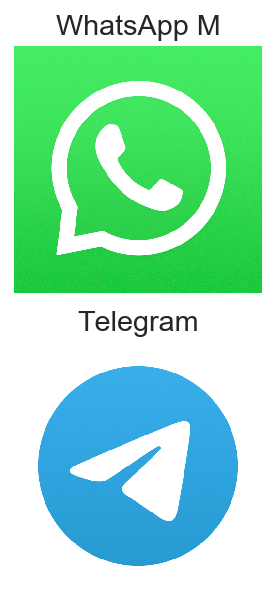

In [7]:
# this function will print the icons of the apps that we are scrapping the data from
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

Store the app information by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file

In [16]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.head(3)

,title,description,descriptionHTML,summary,summaryHTML,installs,minInstalls,score,ratings,reviews,...,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,editorsChoice,appId,url
0,WhatsApp Messenger,WhatsApp from Facebook\r\n\r\nWhatsApp Messeng...,WhatsApp from Facebook<br><br>WhatsApp Messeng...,Simple. Personal. Secure.,Simple. Personal. Secure.,"5,000,000,000+",5000000000,4.174815,129966369,38687346,...,None,False,"Oct 18, 2010",1612246119,Varies with device,* Introducing disappearing messages. Now you c...,* Introducing disappearing messages. Now you c...,True,com.whatsapp,https://play.google.com/store/apps/details?id=...
1,Telegram,"Pure instant messaging — simple, fast, secure,...","Pure instant messaging — simple, fast, secure,...",Telegram is a messaging app with a focus on sp...,Telegram is a messaging app with a focus on sp...,"500,000,000+",500000000,4.491169,7113881,2066935,...,None,False,"Sep 6, 2013",1612039810,Varies with device,• Move your message history from other apps su...,• Move your message history from other apps su...,True,org.telegram.messenger,https://play.google.com/store/apps/details?id=...
2,Signal Private Messenger,Millions of people use Signal every day for fr...,Millions of people use Signal every day for fr...,Say “hello” to privacy.,Say “hello” to privacy.,"50,000,000+",50000000,4.499089,1303988,470517,...,None,False,"May 25, 2010",1612458935,5.3.12,\r\n★ Chat wallpapers have arrived! Choose uni...,<br>★ Chat wallpapers have arrived! Choose uni...,False,org.thoughtcrime.securesms,https://play.google.com/store/apps/details?id=...


In [8]:
# App information Data frame
app_infos_df.to_csv('apps.csv', index=None, header=True)

In [17]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)): 
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]: #taking only the newest and relevant reviews to tell us about current features
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 30 if score == 3 else 15, #Here we are filtering reviews into three categories
        filter_score_with=score
      )
    # ratings 1&2 will be negative sentiment so 5 from each rating
    # rating 3 will be neutral sentiment so 10 reviews from that
    # ratings 4&5 will be positive sentiment so 100 from each rating
    # so we have 200 ratings on each category
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.09s/it]


In [18]:
print_json(app_reviews[0])

{
  "appId": "com.whatsapp",
  "at": "2021-02-07 19:38:35",
  "content": "It doesn't do anything. You download it and it sits idol on your phone while everything you do gets handled by your phone's default SMS app and built-in contact book. Adding people to the app just adds them to your contacts. Chatting with people just opens up your text messaging app. Like, what's the point?",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "2.21.2.18",
  "reviewId": "gp:AOqpTOGY95rLRPCwXSrWh2OeemVm1toKlVEOtcaaBTqHaar9Id48-h3xrtdQe8s4-RkI5zIbgmbF_0cjJGm-ItI",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 659,
  "userImage": "https://play-lh.googleusercontent.com/a-/AOh14GhpSOrKnAIDmky8ZsIRASfbGs37Iy5ylDZSeQor",
  "userName": "Glen Horakh"
}



In [18]:
len(app_reviews)

540

In [19]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOGY95rLRPCwXSrWh2OeemVm1toKlVEOtcaaBTq...,Glen Horakh,https://play-lh.googleusercontent.com/a-/AOh14...,It doesn't do anything. You download it and it...,1,1228,2.21.2.18,2021-02-07 19:38:35,None,None,most_relevant,com.whatsapp
1,gp:AOqpTOHVgSLY7q-8Wo3R3FLiZbGYiydFu9Q5bzgq7Ok...,Taha Riahi,https://play-lh.googleusercontent.com/a-/AOh14...,In one sentence: It's terrible. if you delete ...,1,470,2.21.1.16,2021-02-04 15:27:27,None,None,most_relevant,com.whatsapp
2,gp:AOqpTOGD2_nkJkWdnVc-RxQO-JSXTXOON4lMzRH7UEh...,Md. Abdur Raihan,https://play-lh.googleusercontent.com/a-/AOh14...,It was a fantastic app but experiencing one en...,1,527,2.21.1.13,2021-01-30 07:45:19,None,None,most_relevant,com.whatsapp


In [20]:
app_reviews_df.to_csv('reviews.csv', index=None, header=True)